# Análisis Exploratorio de Datos - Proyecto Salud Ambiental Bogotá

## Objetivo
Explorar y analizar los datos de calidad del aire en Bogotá (2020-2025) para:
- Entender la estructura y calidad de los datos
- Identificar patrones temporales y geográficos de contaminantes
- Preparar el diseño del modelo dimensional para el data mart

## Fuentes de Datos
- **SISAIRE**: Datos horarios de gases contaminantes (CO, O3, NO2, SO2)
- **IBOCA**: Datos horarios de material particulado (PM10, PM2.5)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10

In [6]:
def load_sisaire(pollutant, year):
    """
    Load SISAIRE data for a specific pollutant and year

    Args:
        pollutant: 'CO', 'O3', 'NO2', 'SO2'
        year: year between 2020-2025

    Returns:
        DataFrame with columns: Station, Start_Date, End_Date, Pollutant, Value, Year
    """
    filepath = f"data/SISAIRE-{pollutant}-{year}.csv"
    df = pd.read_csv(filepath)

    df["Estacion"] = df["Estacion"].str.strip('"')

    # Convert date columns to datetime before renaming
    if "Fecha inicial" in df.columns:
        df["Fecha inicial"] = pd.to_datetime(df["Fecha inicial"])
    if "Fecha final" in df.columns:
        df["Fecha final"] = pd.to_datetime(df["Fecha final"])

    df = df.rename(
        columns={
            "Estacion": "Station",
            "Fecha inicial": "Start_Date",
            "Fecha final": "End_Date",
            pollutant: "Value",
        }
    )
    df["Pollutant"] = pollutant
    df["Year"] = year

    df = df[["Station", "Start_Date", "End_Date", "Pollutant", "Value", "Year"]]

    return df


def load_iboca(pm_type, year, semester):
    """
    Load IBOCA data for PM10 or PM2.5

    Args:
        pm_type: 'PM10' or 'PM25'
        year: year between 2020-2025
        semester: 1 or 2

    Returns:
        DataFrame in long format with columns: DateTime, Station, Value, Pollutant, Year, Semester
    """
    filepath = f"data/IBOCA-{pm_type}-{year}-{semester}.xlsx"

    df = pd.read_excel(filepath, skiprows=5)

    date_col = df.columns[0]

    df = df[df[date_col].notna()].copy()

    stations = [
        col for col in df.columns if col != date_col and "Unnamed" not in str(col)
    ]

    df_long = df.melt(
        id_vars=[date_col], value_vars=stations, var_name="Station", value_name="Value"
    )

    df_long = df_long.rename(columns={date_col: "DateTime"})
    df_long["DateTime"] = pd.to_datetime(df_long["DateTime"], errors="coerce")

    df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")

    df_long["Pollutant"] = pm_type
    df_long["Year"] = year
    df_long["Semester"] = semester

    df_long = df_long[df_long["Value"].notna() & df_long["DateTime"].notna()]

    return df_long

## 1. Exploración de Datos SISAIRE (Gases Contaminantes)

Análisis de datos horarios de:
- **CO** - Monóxido de Carbono (µg/m³)
- **O3** - Ozono (µg/m³)
- **NO2** - Dióxido de Nitrógeno (µg/m³)
- **SO2** - Dióxido de Azufre (µg/m³)

In [7]:
print("Loading SISAIRE data for 2022...\n")

pollutants = ["CO", "O3", "NO2", "SO2"]
sisaire_data_2022 = {}

for pollutant in pollutants:
    try:
        df = load_sisaire(pollutant, 2022)
        sisaire_data_2022[pollutant] = df
        print(
            f"✓ {pollutant:4s}: {len(df):,} records | {df['Station'].nunique()} stations"
        )
    except Exception as e:
        print(f"✗ {pollutant}: Error - {e}")

print(
    f"\nTotal SISAIRE 2022 records: {sum(len(df) for df in sisaire_data_2022.values()):,}"
)

Loading SISAIRE data for 2022...

✓ CO  : 145,650 records | 19 stations
✓ O3  : 132,959 records | 18 stations
✓ NO2 : 144,185 records | 19 stations
✓ SO2 : 98,684 records | 14 stations

Total SISAIRE 2022 records: 521,478


In [8]:
print("=" * 80)
print("SISAIRE DATA QUALITY ANALYSIS")
print("=" * 80)

for pollutant, df in sisaire_data_2022.items():
    print(f"\n{'─' * 80}")
    print(f"Pollutant: {pollutant}")
    print(f"{'─' * 80}")

    print(f"\n📊 Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")

    print("\n📅 Time range:")
    print(f"   Start: {df['Start_Date'].min()}")
    print(f"   End:   {df['Start_Date'].max()}")
    print(f"   Days:  {(df['Start_Date'].max() - df['Start_Date'].min()).days}")

    print(f"\n🏢 Stations ({df['Station'].nunique()}):")
    for i, station in enumerate(sorted(df["Station"].unique()), 1):
        count = len(df[df["Station"] == station])
        print(f"   {i:2d}. {station:30s} - {count:6,} records")

    print("\n📈 Pollutant statistics:")
    print(
        f"   Null values:  {df['Value'].isna().sum():,} ({df['Value'].isna().sum() / len(df) * 100:.2f}%)"
    )
    print(f"   Mean:         {df['Value'].mean():.2f}")
    print(f"   Median:       {df['Value'].median():.2f}")
    print(f"   Std Dev:      {df['Value'].std():.2f}")
    print(f"   Minimum:      {df['Value'].min():.2f}")
    print(f"   Maximum:      {df['Value'].max():.2f}")

    Q1 = df["Value"].quantile(0.25)
    Q3 = df["Value"].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df["Value"] < Q1 - 1.5 * IQR) | (df["Value"] > Q3 + 1.5 * IQR)]
    print(
        f"   Outliers (IQR): {len(outliers):,} ({len(outliers) / len(df) * 100:.2f}%)"
    )

print(f"\n{'=' * 80}")

SISAIRE DATA QUALITY ANALYSIS

────────────────────────────────────────────────────────────────────────────────
Pollutant: CO
────────────────────────────────────────────────────────────────────────────────

📊 Dimensions: 145,650 rows × 6 columns

📅 Time range:
   Start: 2022-01-01 00:00:00
   End:   2022-12-31 22:00:00
   Days:  364

🏢 Stations (19):
    1. BOLIVIA                        -  8,532 records
    2. CARVAJAL - SEVILLANA           -  1,844 records
    3. CENTRO DE ALTO RENDIMIENTO     -  8,640 records
    4. CIUDAD BOLÍVAR                 -  8,532 records
    5. COLINA                         -  7,479 records
    6. EL JAZMÍN                      -  8,455 records
    7. GUAYMARAL                      -  7,571 records
    8. KENNEDY                        -  6,547 records
    9. LAS FERIAS                     -  7,688 records
   10. MINAMBIENTE                    -  8,637 records
   11. MÓVIL 7MA                      -  5,494 records
   12. MÓVIL FONTIBÓN                 -  

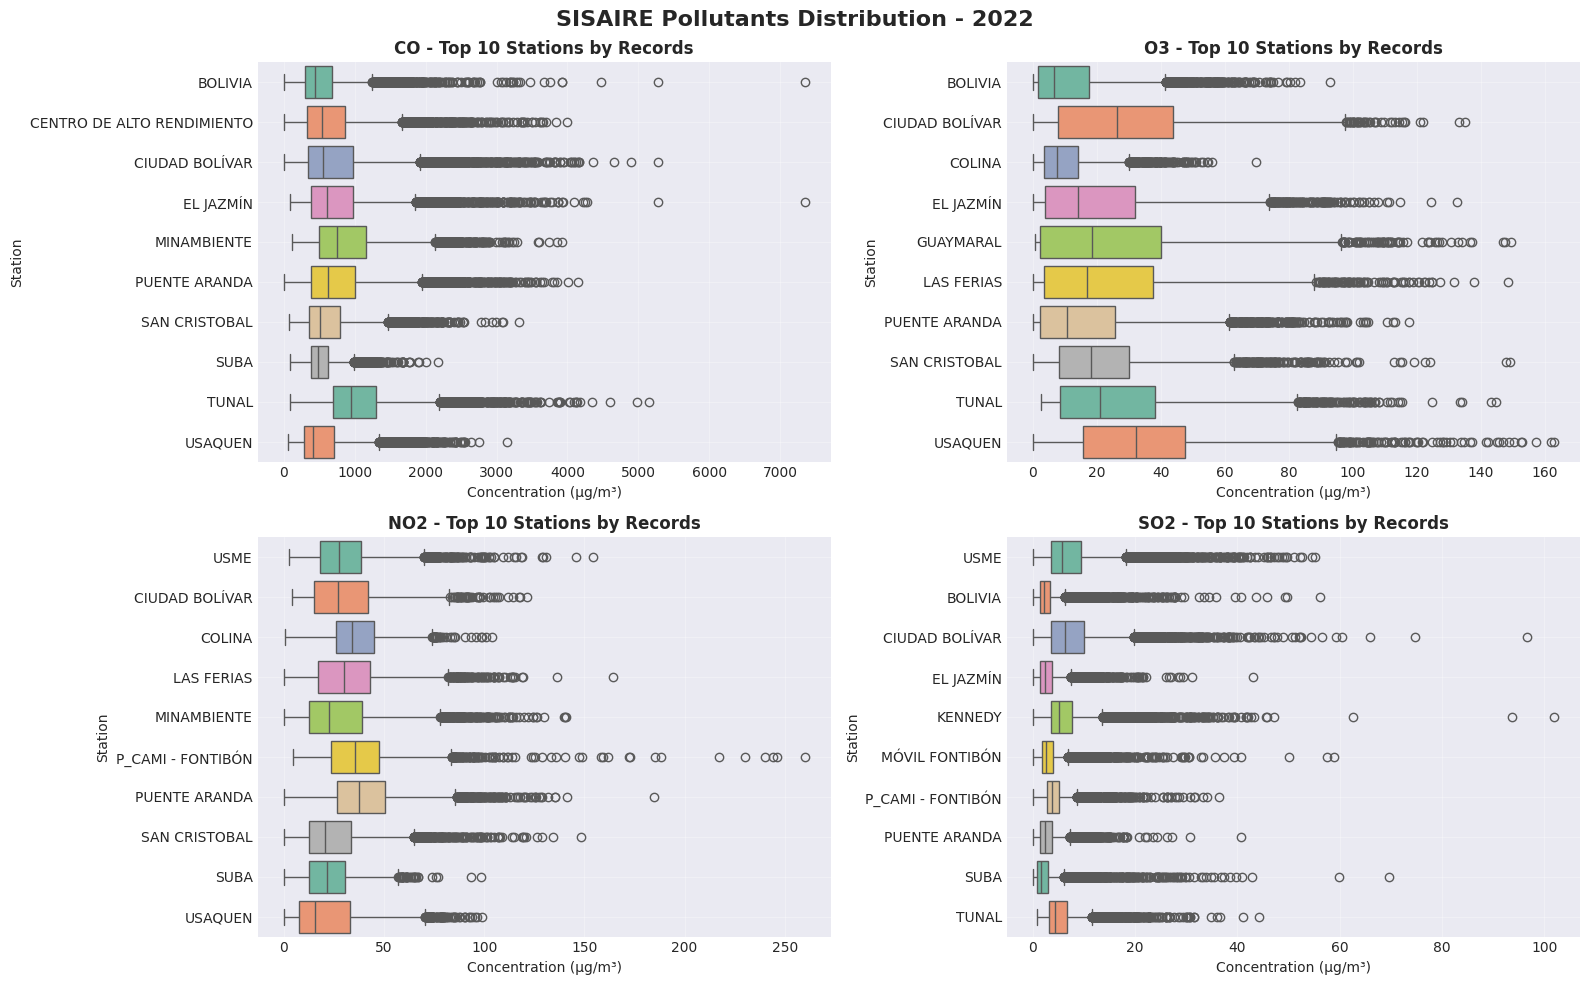

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("SISAIRE Pollutants Distribution - 2022", fontsize=16, fontweight="bold")

for idx, (pollutant, df) in enumerate(sisaire_data_2022.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    Q1 = df["Value"].quantile(0.01)
    Q3 = df["Value"].quantile(0.99)
    df_plot = df[(df["Value"] >= Q1) & (df["Value"] <= Q3)]

    top_stations = df.groupby("Station")["Value"].count().nlargest(10).index
    df_top = df[df["Station"].isin(top_stations)]

    sns.boxplot(data=df_top, y="Station", x="Value", ax=ax, palette="Set2")
    ax.set_title(f"{pollutant} - Top 10 Stations by Records", fontweight="bold")
    ax.set_xlabel("Concentration (µg/m³)")
    ax.set_ylabel("Station")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Exploración de Datos IBOCA (Material Particulado)

Análisis de datos horarios de:
- **PM10** - Partículas menores a 10 micrómetros (µg/m³)
- **PM2.5** - Partículas menores a 2.5 micrómetros (µg/m³)

In [10]:
print("Loading IBOCA data for 2022...\n")

iboca_data_2022 = {}

for pm_type in ["PM10", "PM25"]:
    semester_dfs = []
    for semester in [1, 2]:
        try:
            df = load_iboca(pm_type, 2022, semester)
            semester_dfs.append(df)
            print(
                f"✓ {pm_type} S{semester}: {len(df):,} records | {df['Station'].nunique()} stations"
            )
        except Exception as e:
            print(f"✗ {pm_type} S{semester}: Error - {e}")

    if semester_dfs:
        iboca_data_2022[pm_type] = pd.concat(semester_dfs, ignore_index=True)
        print(f"  Total {pm_type}: {len(iboca_data_2022[pm_type]):,} records\n")

print(f"Total IBOCA 2022 records: {sum(len(df) for df in iboca_data_2022.values()):,}")

Loading IBOCA data for 2022...

✓ PM10 S1: 70,286 records | 19 stations
✓ PM10 S2: 78,345 records | 19 stations
  Total PM10: 148,631 records

✓ PM25 S1: 69,788 records | 19 stations
✓ PM25 S2: 78,343 records | 19 stations
  Total PM25: 148,131 records

Total IBOCA 2022 records: 296,762


In [11]:
print("=" * 80)
print("IBOCA DATA QUALITY ANALYSIS")
print("=" * 80)

for pm_type, df in iboca_data_2022.items():
    print(f"\n{'─' * 80}")
    print(f"Particulate Matter: {pm_type}")
    print(f"{'─' * 80}")

    print(f"\n📊 Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")

    print("\n📅 Time range:")
    print(f"   Start: {df['DateTime'].min()}")
    print(f"   End:   {df['DateTime'].max()}")
    print(f"   Days:  {(df['DateTime'].max() - df['DateTime'].min()).days}")

    print(f"\n🏢 Stations ({df['Station'].nunique()}):")
    for i, station in enumerate(sorted(df["Station"].unique()), 1):
        count = len(df[df["Station"] == station])
        null_pct = df[df["Station"] == station]["Value"].isna().sum() / count * 100
        print(f"   {i:2d}. {station:25s} - {count:7,} records ({null_pct:5.2f}% nulls)")

    print("\n📈 Pollutant statistics:")
    print(
        f"   Null values:  {df['Value'].isna().sum():,} ({df['Value'].isna().sum() / len(df) * 100:.2f}%)"
    )
    valid_values = df["Value"].dropna()
    print(f"   Mean:         {valid_values.mean():.2f}")
    print(f"   Median:       {valid_values.median():.2f}")
    print(f"   Std Dev:      {valid_values.std():.2f}")
    print(f"   Minimum:      {valid_values.min():.2f}")
    print(f"   Maximum:      {valid_values.max():.2f}")

    Q1 = valid_values.quantile(0.25)
    Q3 = valid_values.quantile(0.75)
    IQR = Q3 - Q1
    outliers = valid_values[
        (valid_values < Q1 - 1.5 * IQR) | (valid_values > Q3 + 1.5 * IQR)
    ]
    print(
        f"   Outliers (IQR): {len(outliers):,} ({len(outliers) / len(valid_values) * 100:.2f}%)"
    )

print(f"\n{'=' * 80}")

IBOCA DATA QUALITY ANALYSIS

────────────────────────────────────────────────────────────────────────────────
Particulate Matter: PM10
────────────────────────────────────────────────────────────────────────────────

📊 Dimensions: 148,631 rows × 6 columns

📅 Time range:
   Start: 2022-01-01 00:00:00
   End:   2023-01-01 00:00:00
   Days:  365

🏢 Stations (19):
    1. PM10 µg/m3                -   8,144 records ( 0.00% nulls)
    2. PM10 µg/m3.1              -   5,552 records ( 0.00% nulls)
    3. PM10 µg/m3.10             -   8,374 records ( 0.00% nulls)
    4. PM10 µg/m3.11             -   8,296 records ( 0.00% nulls)
    5. PM10 µg/m3.12             -   7,312 records ( 0.00% nulls)
    6. PM10 µg/m3.13             -   8,016 records ( 0.00% nulls)
    7. PM10 µg/m3.14             -   8,222 records ( 0.00% nulls)
    8. PM10 µg/m3.15             -   8,213 records ( 0.00% nulls)
    9. PM10 µg/m3.16             -   8,015 records ( 0.00% nulls)
   10. PM10 µg/m3.17             -   7,491 

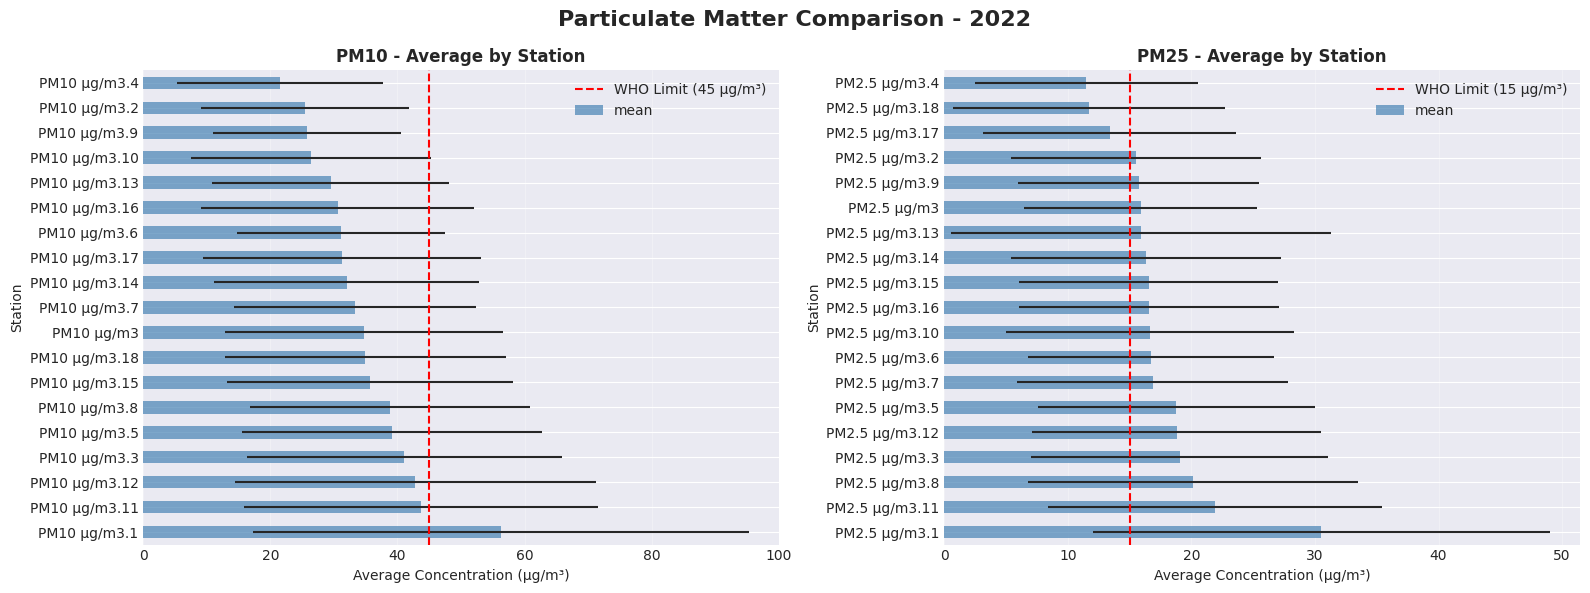

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Particulate Matter Comparison - 2022", fontsize=16, fontweight="bold")

for idx, (pm_type, df) in enumerate(iboca_data_2022.items()):
    ax = axes[idx]

    averages = (
        df.groupby("Station")["Value"]
        .agg(["mean", "std", "count"])
        .sort_values("mean", ascending=False)
    )

    averages = averages[averages["count"] >= 100]

    averages["mean"].plot(
        kind="barh", ax=ax, color="steelblue", alpha=0.7, xerr=averages["std"]
    )
    ax.set_title(f"{pm_type} - Average by Station", fontweight="bold")
    ax.set_xlabel("Average Concentration (µg/m³)")
    ax.set_ylabel("Station")
    ax.grid(True, alpha=0.3, axis="x")

    if pm_type == "PM25":
        ax.axvline(x=15, color="red", linestyle="--", label="WHO Limit (15 µg/m³)")
        ax.legend()
    elif pm_type == "PM10":
        ax.axvline(x=45, color="red", linestyle="--", label="WHO Limit (45 µg/m³)")
        ax.legend()

plt.tight_layout()
plt.show()

## 3. Análisis Temporal

Exploración de tendencias y patrones temporales a lo largo del tiempo

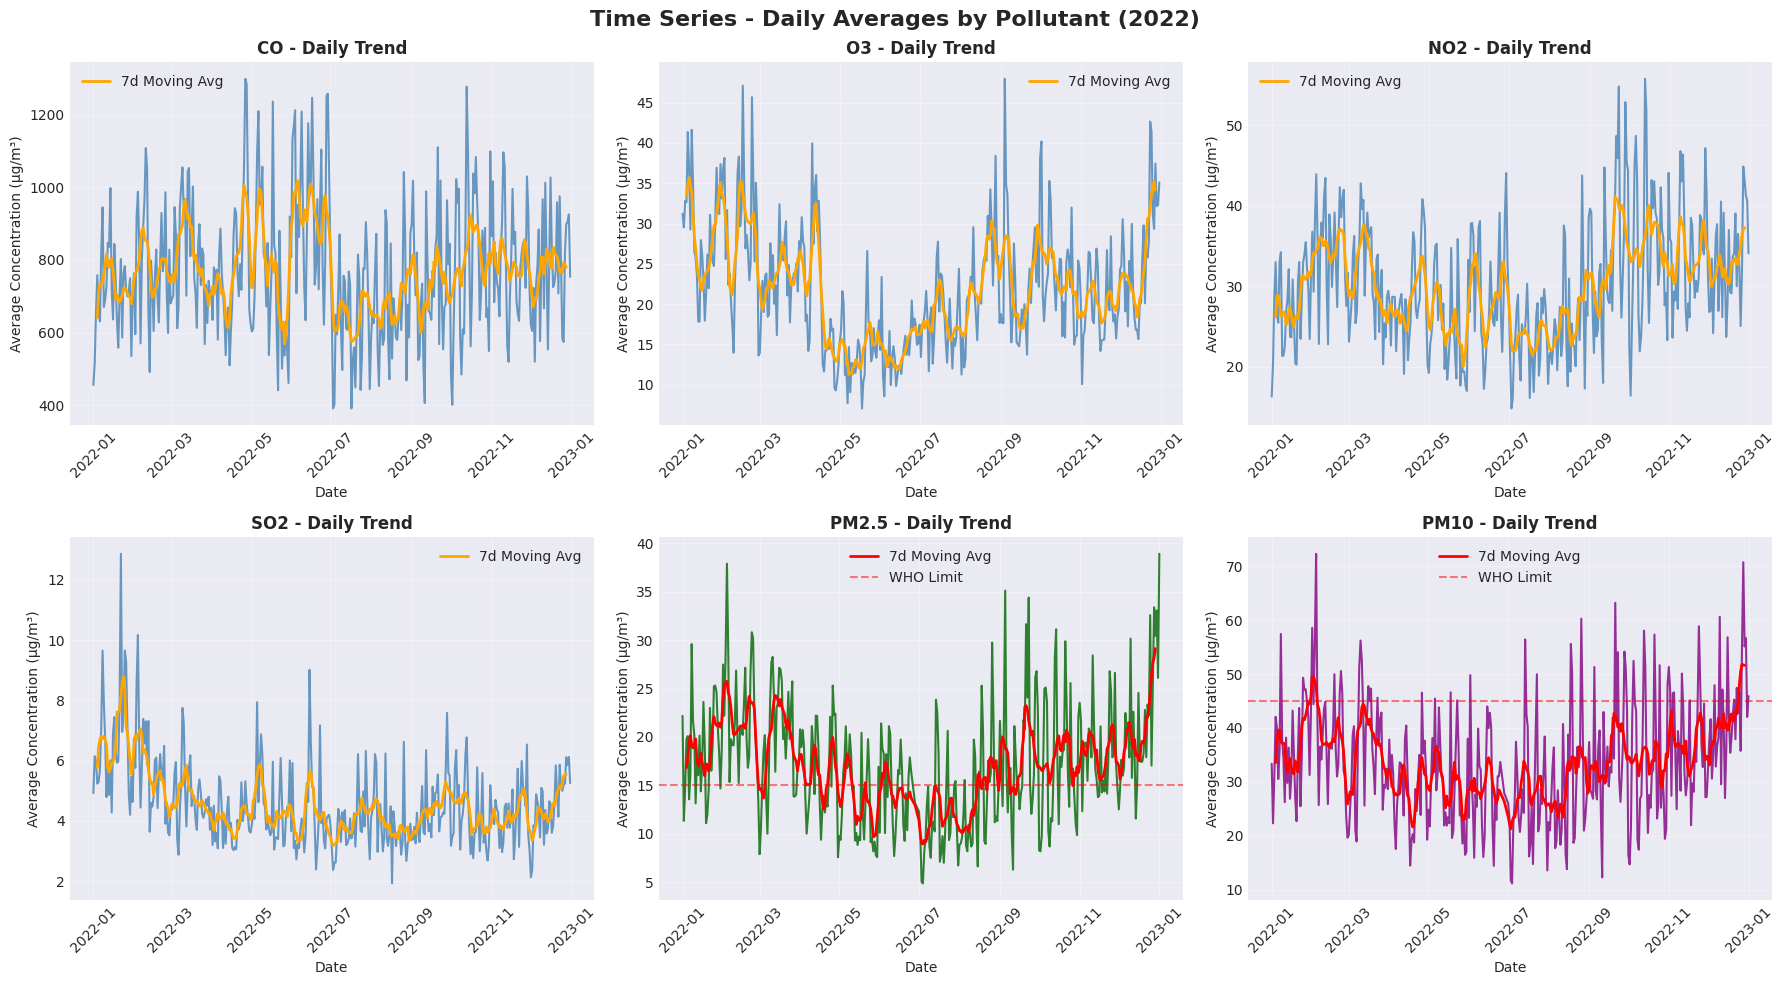

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(
    "Time Series - Daily Averages by Pollutant (2022)", fontsize=16, fontweight="bold"
)

for idx, (pollutant, df) in enumerate(sisaire_data_2022.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    df["Date"] = df["Start_Date"].dt.date
    daily = df.groupby("Date")["Value"].mean().reset_index()
    daily["Date"] = pd.to_datetime(daily["Date"])

    ax.plot(daily["Date"], daily["Value"], linewidth=1.5, color="steelblue", alpha=0.8)
    ax.set_title(f"{pollutant} - Daily Trend", fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Average Concentration (µg/m³)")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=45)

    daily["MA7"] = daily["Value"].rolling(window=7, center=True).mean()
    ax.plot(
        daily["Date"], daily["MA7"], linewidth=2, color="orange", label="7d Moving Avg"
    )
    ax.legend()

if "PM25" in iboca_data_2022:
    ax = axes[1, 1]
    df = iboca_data_2022["PM25"]
    df["Date"] = df["DateTime"].dt.date
    daily = df.groupby("Date")["Value"].mean().reset_index()
    daily["Date"] = pd.to_datetime(daily["Date"])

    ax.plot(daily["Date"], daily["Value"], linewidth=1.5, color="darkgreen", alpha=0.8)
    ax.set_title("PM2.5 - Daily Trend", fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Average Concentration (µg/m³)")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=45)

    daily["MA7"] = daily["Value"].rolling(window=7, center=True).mean()
    ax.plot(
        daily["Date"], daily["MA7"], linewidth=2, color="red", label="7d Moving Avg"
    )
    ax.axhline(y=15, color="red", linestyle="--", alpha=0.5, label="WHO Limit")
    ax.legend()

if "PM10" in iboca_data_2022:
    ax = axes[1, 2]
    df = iboca_data_2022["PM10"]
    df["Date"] = df["DateTime"].dt.date
    daily = df.groupby("Date")["Value"].mean().reset_index()
    daily["Date"] = pd.to_datetime(daily["Date"])

    ax.plot(daily["Date"], daily["Value"], linewidth=1.5, color="purple", alpha=0.8)
    ax.set_title("PM10 - Daily Trend", fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Average Concentration (µg/m³)")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=45)

    daily["MA7"] = daily["Value"].rolling(window=7, center=True).mean()
    ax.plot(
        daily["Date"], daily["MA7"], linewidth=2, color="red", label="7d Moving Avg"
    )
    ax.axhline(y=45, color="red", linestyle="--", alpha=0.5, label="WHO Limit")
    ax.legend()

plt.tight_layout()
plt.show()

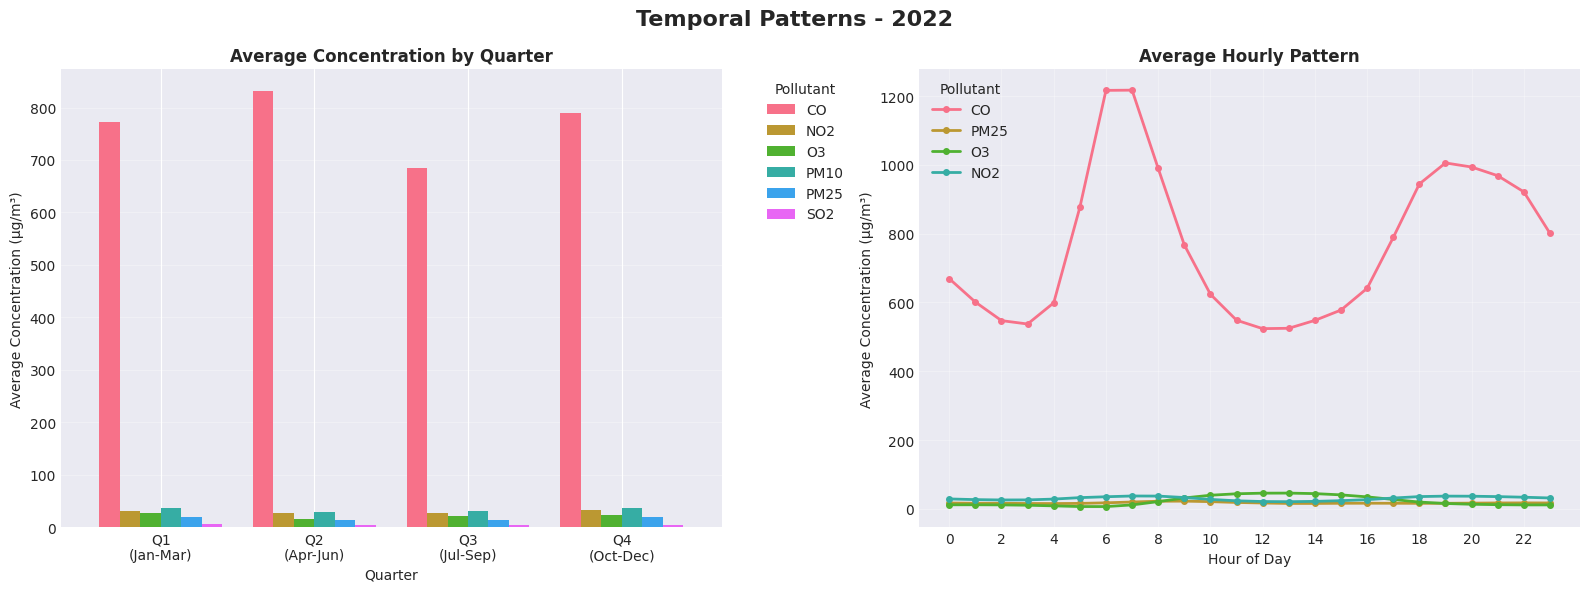

✓ Temporal pattern analysis completed

Observations:
  - Data from 4 quarters
  - Hourly coverage: 0:00 - 23:00


In [14]:
all_data = []

for pollutant, df in sisaire_data_2022.items():
    df_temp = df.copy()
    df_temp["Month"] = df_temp["Start_Date"].dt.month
    df_temp["Quarter"] = df_temp["Start_Date"].dt.quarter
    df_temp["Hour"] = df_temp["Start_Date"].dt.hour
    all_data.append(df_temp[["Pollutant", "Value", "Month", "Quarter", "Hour"]])

for pm_type, df in iboca_data_2022.items():
    df_temp = df.copy()
    df_temp["Month"] = df_temp["DateTime"].dt.month
    df_temp["Quarter"] = df_temp["DateTime"].dt.quarter
    df_temp["Hour"] = df_temp["DateTime"].dt.hour
    all_data.append(df_temp[["Pollutant", "Value", "Month", "Quarter", "Hour"]])

temporal_df = pd.concat(all_data, ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Temporal Patterns - 2022", fontsize=16, fontweight="bold")

ax = axes[0]
quarter_stats = temporal_df.groupby(["Quarter", "Pollutant"])["Value"].mean().unstack()
quarter_stats.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Average Concentration by Quarter", fontweight="bold")
ax.set_xlabel("Quarter")
ax.set_ylabel("Average Concentration (µg/m³)")
ax.set_xticklabels(
    ["Q1\n(Jan-Mar)", "Q2\n(Apr-Jun)", "Q3\n(Jul-Sep)", "Q4\n(Oct-Dec)"], rotation=0
)
ax.legend(title="Pollutant", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3, axis="y")

ax = axes[1]
hour_stats = temporal_df.groupby(["Hour", "Pollutant"])["Value"].mean().unstack()
key_pollutants = ["CO", "PM25", "O3", "NO2"]
hour_stats_filtered = hour_stats[[p for p in key_pollutants if p in hour_stats.columns]]
hour_stats_filtered.plot(ax=ax, linewidth=2, marker="o", markersize=4)
ax.set_title("Average Hourly Pattern", fontweight="bold")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Concentration (µg/m³)")
ax.set_xticks(range(0, 24, 2))
ax.legend(title="Pollutant")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Temporal pattern analysis completed")
print("\nObservations:")
print(f"  - Data from {temporal_df['Quarter'].nunique()} quarters")
print(
    f"  - Hourly coverage: {temporal_df['Hour'].min()}:00 - {temporal_df['Hour'].max()}:00"
)

## 4. Análisis Geográfico y Correlaciones

Exploración de patrones espaciales y relaciones entre contaminantes

In [15]:
print("=" * 80)
print("STATION RANKING - Average Concentrations (2022)")
print("=" * 80)

station_rankings = []

for pollutant, df in sisaire_data_2022.items():
    station_data = (
        df.groupby("Station")["Value"].agg(["mean", "std", "count"]).reset_index()
    )
    station_data["Pollutant"] = pollutant
    station_rankings.append(station_data)

for pm_type, df in iboca_data_2022.items():
    station_pm = (
        df.groupby("Station")["Value"].agg(["mean", "std", "count"]).reset_index()
    )
    station_pm["Pollutant"] = pm_type
    station_rankings.append(station_pm)

ranking_df = pd.concat(station_rankings, ignore_index=True)

all_pollutants = ranking_df["Pollutant"].unique()

for pollutant in all_pollutants:
    print(f"\n{pollutant}")
    print(f"{'─' * 80}")
    top10 = ranking_df[ranking_df["Pollutant"] == pollutant].nlargest(10, "mean")

    for idx, row in top10.iterrows():
        print(
            f"  {row['Station']:30s} | {row['mean']:8.2f} µg/m³ (±{row['std']:.2f}) | {row['count']:,} records"
        )

print(f"\n{'=' * 80}")

STATION RANKING - Average Concentrations (2022)

CO
────────────────────────────────────────────────────────────────────────────────
  CARVAJAL - SEVILLANA           |  2474.20 µg/m³ (±1794.25) | 1,844 records
  MÓVIL 7MA                      |  1744.98 µg/m³ (±524.33) | 5,494 records
  TUNAL                          |  1071.88 µg/m³ (±550.75) | 8,560 records
  KENNEDY                        |   955.00 µg/m³ (±588.06) | 6,547 records
  LAS FERIAS                     |   931.78 µg/m³ (±522.20) | 7,688 records
  MINAMBIENTE                    |   900.42 µg/m³ (±514.87) | 8,637 records
  MÓVIL FONTIBÓN                 |   879.99 µg/m³ (±509.96) | 7,195 records
  PUENTE ARANDA                  |   775.05 µg/m³ (±560.56) | 8,570 records
  EL JAZMÍN                      |   773.24 µg/m³ (±552.87) | 8,455 records
  CIUDAD BOLÍVAR                 |   761.18 µg/m³ (±624.31) | 8,532 records

O3
────────────────────────────────────────────────────────────────────────────────
  USAQUEN            

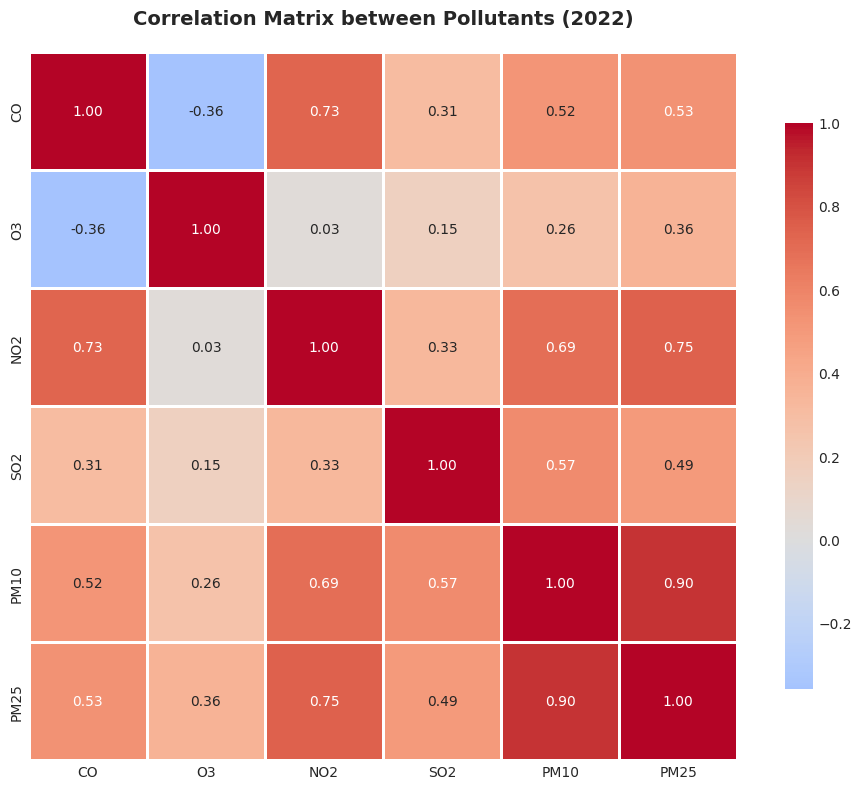

✓ Correlation matrix generated

Strongest correlations:
       Pair  Correlation
PM10 - PM25     0.897387
 NO2 - PM25     0.749383
   CO - NO2     0.729125
 NO2 - PM10     0.691083
 SO2 - PM10     0.566350
  CO - PM25     0.534924
  CO - PM10     0.521177
 SO2 - PM25     0.492194
    CO - O3    -0.359379
  O3 - PM25     0.358833


In [16]:
correlation_data = []

for pollutant, df in sisaire_data_2022.items():
    df_temp = df.copy()
    df_temp["Date"] = df_temp["Start_Date"].dt.date
    daily = df_temp.groupby(["Date", "Station"])["Value"].mean().reset_index()
    daily = daily.pivot(index="Date", columns="Station", values="Value")
    daily_mean = daily.mean(axis=1).to_frame(name=pollutant)
    correlation_data.append(daily_mean)

for pm_type, df in iboca_data_2022.items():
    df_temp = df.copy()
    df_temp["Date"] = df_temp["DateTime"].dt.date
    daily = df_temp.groupby(["Date", "Station"])["Value"].mean().reset_index()
    daily = daily.pivot(index="Date", columns="Station", values="Value")
    daily_mean = daily.mean(axis=1).to_frame(name=pm_type)
    correlation_data.append(daily_mean)

corr_df = pd.concat(correlation_data, axis=1)

correlation = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title(
    "Correlation Matrix between Pollutants (2022)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.tight_layout()
plt.show()

print("✓ Correlation matrix generated")
print("\nStrongest correlations:")
correlation_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i + 1, len(correlation.columns)):
        correlation_pairs.append(
            {
                "Pair": f"{correlation.columns[i]} - {correlation.columns[j]}",
                "Correlation": correlation.iloc[i, j],
            }
        )

pairs_df = pd.DataFrame(correlation_pairs).sort_values(
    "Correlation", ascending=False, key=abs
)
print(pairs_df.head(10).to_string(index=False))

## 5. Resumen y Diseño del Modelo Dimensional

Síntesis de hallazgos y propuesta de estructura para el Data Mart

In [17]:
print("=" * 100)
print("DATA EXPLORATION SUMMARY - ENVIRONMENTAL HEALTH PROJECT BOGOTÁ")
print("=" * 100)

print("\n📊 DATA VOLUME (2022)")
print("─" * 100)
print(
    f"{'Source':<15} {'Pollutant':<15} {'Records':>15} {'Stations':>12} {'Granularity':<20}"
)
print("─" * 100)

for pollutant, df in sisaire_data_2022.items():
    print(
        f"{'SISAIRE':<15} {pollutant:<15} {len(df):>15,} {df['Station'].nunique():>12} {'Hourly':<20}"
    )

for pm_type, df in iboca_data_2022.items():
    print(
        f"{'IBOCA':<15} {pm_type:<15} {len(df):>15,} {df['Station'].nunique():>12} {'Hourly':<20}"
    )

total_records = sum(len(df) for df in sisaire_data_2022.values()) + sum(
    len(df) for df in iboca_data_2022.values()
)
print("─" * 100)
print(f"{'TOTAL':<15} {'':<15} {total_records:>15,}")

print("\n\n🏢 GEOGRAPHIC COVERAGE")
print("─" * 100)

all_sisaire_stations = set()
for df in sisaire_data_2022.values():
    all_sisaire_stations.update(df["Station"].unique())

all_iboca_stations = set()
for df in iboca_data_2022.values():
    all_iboca_stations.update(df["Station"].unique())

print(f"  • SISAIRE Stations: {len(all_sisaire_stations)}")
print(f"  • IBOCA Stations:   {len(all_iboca_stations)}")
print(f"  • Common Stations:  {len(all_sisaire_stations & all_iboca_stations)}")

print("\n\n📈 DESCRIPTIVE STATISTICS BY POLLUTANT")
print("─" * 100)
print(
    f"{'Pollutant':<15} {'Mean':>12} {'Median':>12} {'Std Dev':>12} {'Min':>12} {'Max':>12} {'Unit':<15}"
)
print("─" * 100)

for pollutant, df in sisaire_data_2022.items():
    stats = df["Value"].describe()
    print(
        f"{pollutant:<15} {stats['mean']:>12.2f} {stats['50%']:>12.2f} {stats['std']:>12.2f} {stats['min']:>12.2f} {stats['max']:>12.2f} {'µg/m³':<15}"
    )

for pm_type, df in iboca_data_2022.items():
    stats = df["Value"].describe()
    print(
        f"{pm_type:<15} {stats['mean']:>12.2f} {stats['50%']:>12.2f} {stats['std']:>12.2f} {stats['min']:>12.2f} {stats['max']:>12.2f} {'µg/m³':<15}"
    )

print("\n\n⚠️  DATA QUALITY")
print("─" * 100)
print(f"{'Source':<15} {'Pollutant':<15} {'% Nulls':>12} {'% Outliers':>15}")
print("─" * 100)

for pollutant, df in sisaire_data_2022.items():
    null_pct = df["Value"].isna().sum() / len(df) * 100
    Q1, Q3 = df["Value"].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = df[(df["Value"] < Q1 - 1.5 * IQR) | (df["Value"] > Q3 + 1.5 * IQR)]
    outlier_pct = len(outliers) / len(df) * 100
    print(f"{'SISAIRE':<15} {pollutant:<15} {null_pct:>12.2f}% {outlier_pct:>15.2f}%")

for pm_type, df in iboca_data_2022.items():
    null_pct = df["Value"].isna().sum() / len(df) * 100
    values = df["Value"].dropna()
    Q1, Q3 = values.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = values[(values < Q1 - 1.5 * IQR) | (values > Q3 + 1.5 * IQR)]
    outlier_pct = len(outliers) / len(values) * 100
    print(f"{'IBOCA':<15} {pm_type:<15} {null_pct:>12.2f}% {outlier_pct:>15.2f}%")

print("\n" + "=" * 100)

DATA EXPLORATION SUMMARY - ENVIRONMENTAL HEALTH PROJECT BOGOTÁ

📊 DATA VOLUME (2022)
────────────────────────────────────────────────────────────────────────────────────────────────────
Source          Pollutant               Records     Stations Granularity         
────────────────────────────────────────────────────────────────────────────────────────────────────
SISAIRE         CO                      145,650           19 Hourly              
SISAIRE         O3                      132,959           18 Hourly              
SISAIRE         NO2                     144,185           19 Hourly              
SISAIRE         SO2                      98,684           14 Hourly              
IBOCA           PM10                    148,631           19 Hourly              
IBOCA           PM25                    148,131           19 Hourly              
────────────────────────────────────────────────────────────────────────────────────────────────────
TOTAL                                 

In [18]:
print("\n" + "=" * 100)
print("PROPUESTA DE MODELO DIMENSIONAL - DATA MART DE CALIDAD DEL AIRE")
print("=" * 100)

print("\n\n🎯 TABLA DE HECHOS: Hecho_Medicion_Calidad_Aire")
print("─" * 100)
print("""
Granularidad: Una fila por cada medición horaria de un contaminante en una estación

Medidas (Hechos):
  • concentracion_valor     (DECIMAL)  - Valor medido del contaminante [ADITIVA]
  • concentracion_min       (DECIMAL)  - Valor mínimo en la hora [SEMI-ADITIVA]
  • concentracion_max       (DECIMAL)  - Valor máximo en la hora [SEMI-ADITIVA]
  • concentracion_promedio  (DECIMAL)  - Promedio en la hora [SEMI-ADITIVA]
  • num_mediciones          (INTEGER)  - Cantidad de mediciones [ADITIVA]
  • indicador_limite_oms    (BOOLEAN)  - Supera límite OMS [NO-ADITIVA]
  • indice_calidad_aire     (VARCHAR)  - Categoría (Bueno, Moderado, etc.) [NO-ADITIVA]

Claves Foráneas:
  • dim_tiempo_id
  • dim_estacion_id
  • dim_contaminante_id
  • dim_fecha_id
""")

print("\n📅 DIMENSIÓN: Dim_Tiempo")
print("─" * 100)
print("""
Tipo: Dimension Estándar de Tiempo

Atributos:
  • tiempo_id (PK)
  • fecha_completa         - YYYY-MM-DD HH:00:00
  • año
  • mes                    - 1-12
  • mes_nombre             - Enero, Febrero, ...
  • trimestre              - Q1, Q2, Q3, Q4
  • semestre               - S1, S2
  • dia_mes
  • dia_semana             - 1-7
  • dia_semana_nombre      - Lunes, Martes, ...
  • hora                   - 0-23
  • periodo_dia            - Madrugada, Mañana, Tarde, Noche
  • es_fin_semana          - BOOLEAN

SCD: No aplica (dimensión estática)
""")

print("\n🏢 DIMENSIÓN: Dim_Estacion")
print("─" * 100)
print("""
Tipo: Slowly Changing Dimension Tipo 2 (mantiene historia)

Atributos:
  • estacion_id (PK Surrogate)
  • estacion_codigo        - Código natural de la estación
  • estacion_nombre
  • localidad              - Localidad de Bogotá
  • direccion
  • latitud
  • longitud
  • altitud
  • tipo_zona              - Urbana, Suburbana, Rural
  • categoria              - Tráfico, Industrial, Residencial
  • fuente_datos           - SISAIRE, IBOCA
  • fecha_inicio           - Inicio vigencia registro
  • fecha_fin              - Fin vigencia registro (NULL si actual)
  • es_actual              - BOOLEAN

SCD Tipo 2: Se crea nuevo registro si cambian atributos físicos/clasificación
Justificación: Permite analizar cambios históricos en clasificación/ubicación de estaciones
""")

print("\n🌫️  DIMENSIÓN: Dim_Contaminante")
print("─" * 100)
print("""
Tipo: Dimension Estándar

Atributos:
  • contaminante_id (PK)
  • codigo                 - CO, O3, NO2, SO2, PM10, PM25
  • nombre_completo        - Monóxido de Carbono, Ozono, ...
  • formula_quimica        - CO, O₃, NO₂, SO₂, PM₁₀, PM₂.₅
  • unidad_medida          - µg/m³
  • limite_oms_anual       - Límite anual OMS
  • limite_oms_diario      - Límite diario OMS (si aplica)
  • categoria              - Gas, Partícula
  • fuente_datos           - SISAIRE, IBOCA
  • descripcion
  • efectos_salud

SCD: No aplica (catálogo estático)
""")

print("\n📆 DIMENSIÓN: Dim_Fecha (Dimensión Junk)")
print("─" * 100)
print("""
Tipo: Dimension Degenerada / Junk

Atributos:
  • fecha_id (PK)
  • fecha                  - YYYY-MM-DD
  • año
  • mes
  • dia

SCD: No aplica
Nota: Separada de Dim_Tiempo para optimizar agregaciones diarias
""")

print("\n\n💡 INDICADORES CALCULADOS SUGERIDOS")
print("─" * 100)
print("""
Para Tableros de Control:

Análisis Descriptivo:
  • Concentración promedio por localidad/estación/contaminante
  • Número de excedencias a límites OMS
  • Días con calidad de aire "dañina"
  • Tendencia temporal (diaria, mensual, trimestral)
  
Estadística Inferencial:
  • Intervalos de confianza para promedios por localidad
  • Pruebas de hipótesis: diferencia entre localidades alta vs baja exposición
  • OR/RR: Riesgo relativo de exceder límites OMS por zona
  • Regresión: Relación concentración PM2.5 vs tiempo/localidad
  
Análisis Clínico:
  • Promedios trimestrales PM2.5 por localidad (para correlacionar con bajo peso al nacer)
  • Clasificación de localidades por percentiles de exposición
  • Días-persona de exposición alta (>40 µg/m³)
""")

print("\n\n🔧 CONSIDERACIONES TÉCNICAS DEL ETL")
print("─" * 100)
print("""
1. Limpieza de datos:
   - Normalizar nombres de estaciones (quitar comillas, estandarizar mayúsculas)
   - Manejar valores nulos y outliers (definir reglas de negocio)
   - Convertir "Sin data" de IBOCA a NULL
   
2. Transformaciones:
   - Pivotar datos IBOCA de formato ancho a largo
   - Unificar estructuras SISAIRE e IBOCA
   - Calcular indicadores de calidad del aire (ICA)
   - Generar claves surrogadas
   
3. Enriquecimiento:
   - Agregar información geográfica (localidad, coordenadas)
   - Mapear estaciones a zonas socioeconómicas
   - Calcular categorías de índice de calidad del aire
   
4. Carga incremental:
   - Diseñar para carga por semestre (IBOCA) o año (SISAIRE)
   - Implementar SCD Tipo 2 para Dim_Estacion
   - Validar duplicados por timestamp + estación + contaminante
""")

print("\n" + "=" * 100)
print("FIN DEL ANÁLISIS EXPLORATORIO")
print("=" * 100)


PROPUESTA DE MODELO DIMENSIONAL - DATA MART DE CALIDAD DEL AIRE


🎯 TABLA DE HECHOS: Hecho_Medicion_Calidad_Aire
────────────────────────────────────────────────────────────────────────────────────────────────────

Granularidad: Una fila por cada medición horaria de un contaminante en una estación

Medidas (Hechos):
  • concentracion_valor     (DECIMAL)  - Valor medido del contaminante [ADITIVA]
  • concentracion_min       (DECIMAL)  - Valor mínimo en la hora [SEMI-ADITIVA]
  • concentracion_max       (DECIMAL)  - Valor máximo en la hora [SEMI-ADITIVA]
  • concentracion_promedio  (DECIMAL)  - Promedio en la hora [SEMI-ADITIVA]
  • num_mediciones          (INTEGER)  - Cantidad de mediciones [ADITIVA]
  • indicador_limite_oms    (BOOLEAN)  - Supera límite OMS [NO-ADITIVA]
  • indice_calidad_aire     (VARCHAR)  - Categoría (Bueno, Moderado, etc.) [NO-ADITIVA]

Claves Foráneas:
  • dim_tiempo_id
  • dim_estacion_id
  • dim_contaminante_id
  • dim_fecha_id


📅 DIMENSIÓN: Dim_Tiempo
───────